In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')

# Folder directory for the figures of this notebook
figure_folder = r'C:/Users/Admin/Desktop/lab_optique/data/fibre_optique/'

## Semaine 1:
Objectifs de la semaine; 
- Caractérisation de la fibre multimode (ouverture numérique, V, nombre de modes)
- Caractérisation des deux fibres monomodes (ouverture numérique, V, nombre de modes).

On commence par la fibre multimode
### Fibre multimode
Notre premier objectif est de faire une régression linéaire pour les valeurs distance vs diamètre pour le patron vu sur l'écran. 

In [36]:
# Importing the data
fname = figure_folder + r"multimode_mesures.txt"
data = np.loadtxt(fname, skiprows=1)
diameter, distance = data[:, 0], data[:, 1] # cm
sigma_diameter, sigma_distance = 1e-1, 1e-1 # cm la demi-mesure la plus petite de la règle

In [40]:
Regression_multimode = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_diameter
)


params_fitted, std_fitted = Regression_multimode.fit(
    obs = ..., 
    x = ...,
    ridge_reg = 1e-12,
    fit_intercept = ...
)

cov = Regression_multimode.cov()
chi2 = Regression_multimode.compute_chi2(obs = ...)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)

TypeError: unsupported operand type(s) for ** or pow(): 'ellipsis' and 'int'

AttributeError: module 'matplotlib.pyplot' has no attribute 'axs'

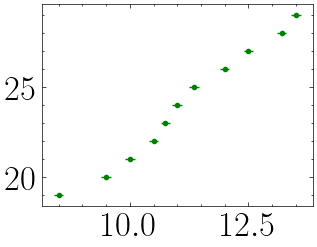

In [37]:
plt.errorbar(diameter, distance,  xerr = sigma_diameter, yerr = sigma_distance, fmt = ".", color = "green")
plt.pl